## PREPROCESSING DATA

### slice into 32kb windows

In [173]:
import numpy as np
from pathlib import Path
import os
import numpy as np
import pandas as pd
from Crypto.Cipher import AES
import zlib
from scipy.fft import fft
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

WINDOW_SIZE = 32 * 1024  # 32 KB

In [174]:
def slice_file_bytes(file_path, window_size=WINDOW_SIZE):
    """Read a file as bytes and slice into 32 KB windows."""
    with open(file_path, "rb") as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    windows = []
    for i in range(0, len(data), window_size):
        chunk = data[i:i+window_size]
        if len(chunk) == window_size:
            windows.append(chunk)
    return windows

In [175]:
plaintext_dirs = ["data/plaintext/text", "data/plaintext/code", "data/plaintext/raw_images"]

plain_windows = []
window_sources = []

for d in plaintext_dirs:
    for f in Path(d).iterdir():
        if f.is_file():
            windows = slice_file_bytes(f)
            plain_windows.extend(windows)
            window_sources.extend([str(f)] * len(windows))

print("Total 32 KB windows:", len(plain_windows))

Total 32 KB windows: 4246


In [176]:
print("First window shape:", plain_windows[0].shape)
print("Source file:", window_sources[0])
print("Entropy:", -np.sum((np.bincount(plain_windows[0], minlength=256)/WINDOW_SIZE) * 
                          np.log2(np.bincount(plain_windows[0], minlength=256)/WINDOW_SIZE + 1e-10)))


First window shape: (32768,)
Source file: data\plaintext\text\Computer_security.txt
Entropy: 4.531695808872447


### create high entropy class

In [177]:
def random_key_iv():
    key = os.urandom(16)  # AES-128
    iv = os.urandom(16)
    return key, iv

def pad(data):
    # PKCS7 padding for AES
    pad_len = 16 - (len(data) % 16)
    return data + bytes([pad_len] * pad_len)

def aes_cbc_encrypt(window):
    key, iv = random_key_iv()
    cipher = AES.new(key, AES.MODE_CBC, iv)
    return cipher.encrypt(pad(window.tobytes()))

def aes_ctr_encrypt(window):
    key, iv = random_key_iv()
    cipher = AES.new(key, AES.MODE_CTR, nonce=iv[:8])
    return cipher.encrypt(window.tobytes())

def aes_ecb_encrypt(window):
    key = os.urandom(16)
    cipher = AES.new(key, AES.MODE_ECB)
    return cipher.encrypt(pad(window.tobytes()))


In [178]:
def random_bytes(window_size=WINDOW_SIZE):
    return os.urandom(window_size)

def zlib_compress_bytes(window):
    compressed = zlib.compress(window.tobytes())
    # Slice into 32 KB windows if large enough
    windows = []
    for i in range(0, len(compressed), WINDOW_SIZE):
        chunk = compressed[i:i+WINDOW_SIZE]
        if len(chunk) == WINDOW_SIZE:
            windows.append(chunk)
    return windows


In [179]:
high_entropy_windows = []
labels = []

for w in plain_windows:
    # AES-CBC
    try:
        enc_cbc = aes_cbc_encrypt(w)
        for i in range(0, len(enc_cbc), WINDOW_SIZE):
            chunk = enc_cbc[i:i+WINDOW_SIZE]
            if len(chunk) == WINDOW_SIZE:
                high_entropy_windows.append(np.frombuffer(chunk, dtype=np.uint8))
                labels.append("AES-CBC")
    except:
        pass
    
    # AES-CTR
    try:
        enc_ctr = aes_ctr_encrypt(w)
        for i in range(0, len(enc_ctr), WINDOW_SIZE):
            chunk = enc_ctr[i:i+WINDOW_SIZE]
            if len(chunk) == WINDOW_SIZE:
                high_entropy_windows.append(np.frombuffer(chunk, dtype=np.uint8))
                labels.append("AES-CTR")
    except:
        pass

    # AES-ECB (demo)
    try:
        enc_ecb = aes_ecb_encrypt(w)
        for i in range(0, len(enc_ecb), WINDOW_SIZE):
            chunk = enc_ecb[i:i+WINDOW_SIZE]
            if len(chunk) == WINDOW_SIZE:
                high_entropy_windows.append(np.frombuffer(chunk, dtype=np.uint8))
                labels.append("AES-ECB")
    except:
        pass

    # Random bytes
    rb = random_bytes()
    high_entropy_windows.append(np.frombuffer(rb, dtype=np.uint8))
    labels.append("Random")

    # zlib-compressed
    compressed_windows = zlib_compress_bytes(w)
    for cw in compressed_windows:
        high_entropy_windows.append(np.frombuffer(cw, dtype=np.uint8))
        labels.append("zlib")


In [180]:
print("Total high-entropy windows:", len(high_entropy_windows))
print("First 5 labels:", labels[:5])
print("Entropy first window:", -np.sum((np.bincount(high_entropy_windows[0], minlength=256)/WINDOW_SIZE) *
                                      np.log2(np.bincount(high_entropy_windows[0], minlength=256)/WINDOW_SIZE + 1e-10)))


Total high-entropy windows: 16984
First 5 labels: ['AES-CBC', 'AES-CTR', 'AES-ECB', 'Random', 'AES-CBC']
Entropy first window: 7.994415272058879


### compute features

In [181]:
def shannon_entropy(window):
    hist = np.bincount(window, minlength=256)
    p = hist / hist.sum()
    p = p[p > 0]
    return -np.sum(p * np.log2(p))

def chi_square_uniform(window):
    hist = np.bincount(window, minlength=256)
    expected = np.ones(256) * len(window) / 256
    chi2, _ = chisquare(hist, f_exp=expected)
    return chi2

def compressibility(window):
    compressed = zlib.compress(window.tobytes())
    return len(compressed) / len(window)

def serial_correlation(window):
    x = window.astype(np.float32)
    if len(x) < 2:
        return 0
    return np.corrcoef(x[:-1], x[1:])[0, 1]

def fft_flatness(window):
    spectrum = np.abs(fft(window))
    spectrum = spectrum[spectrum > 0]
    geometric_mean = np.exp(np.mean(np.log(spectrum)))
    arithmetic_mean = np.mean(spectrum)
    return geometric_mean / arithmetic_mean

def ecb_block_duplicates(window, block_size=16):
    blocks = [bytes(window[i:i+block_size]) for i in range(0, len(window), block_size)]
    if len(blocks) == 0:
        return 0
    num_unique = len(set(blocks))
    num_total = len(blocks)
    return 1 - num_unique / num_total

def compute_features(windows):
    feats = []
    for w in windows:
        w = np.array(w, dtype=np.uint8)
        feats.append([
            shannon_entropy(w),
            chi_square_uniform(w),
            compressibility(w),
            serial_correlation(w),
            fft_flatness(w),
            ecb_block_duplicates(w)
        ])
    return np.array(feats, dtype=np.float32)

In [182]:
X_plain = compute_features(plain_windows)
X_entropy = compute_features(high_entropy_windows)

print("Plaintext features shape:", X_plain.shape)
print("High-entropy features shape:", X_entropy.shape)

Plaintext features shape: (4246, 6)
High-entropy features shape: (16984, 6)


In [183]:
feature_names = ["Entropy","Chi2","Compressibility","SerialCorr","FFTFlatness","ECBBlocks"]

plain_mean = np.mean(X_plain, axis=0)
plain_std  = np.std(X_plain, axis=0)

algo_list = np.unique(labels)
high_entropy_summary = []

for algo in algo_list:
    idx = [i for i, l in enumerate(labels) if l == algo]
    X_algo = X_entropy[idx]
    mean_vals = np.mean(X_algo, axis=0)
    std_vals  = np.std(X_algo, axis=0)
    high_entropy_summary.append([algo] + list(mean_vals) + list(std_vals))

columns = ["Algorithm"] + [f"{f}_mean" for f in feature_names] + [f"{f}_std" for f in feature_names]

summary_data = [["Plaintext"] + list(plain_mean) + list(plain_std)] + high_entropy_summary

summary_df = pd.DataFrame(summary_data, columns=columns)
summary_df = summary_df.round(4)

summary_df


,Algorithm,Entropy_mean,Chi2_mean,Compressibility_mean,SerialCorr_mean,FFTFlatness_mean,ECBBlocks_mean,Entropy_std,Chi2_std,Compressibility_std,SerialCorr_std,FFTFlatness_std,ECBBlocks_std
0,Plaintext,6.8420,70911.640625,0.6346,0.0502,0.2696,0.0036,0.4126,235673.515625,0.1704,0.2968,0.0436,0.0423
1,AES-CBC,7.9943,255.512207,1.0005,0.0001,0.8367,0.0000,0.0005,22.540701,0.0000,0.0056,0.0017,0.0000
2,AES-CTR,7.9943,255.304703,1.0005,0.0001,0.8367,0.0000,0.0005,22.634501,0.0000,0.0055,0.0018,0.0000
3,AES-ECB,7.9887,909.268127,0.9976,-0.0000,0.8364,0.0036,0.1083,12898.180664,0.0415,0.0108,0.0064,0.0423
4,Random,7.9944,254.585007,1.0005,-0.0002,0.8367,0.0000,0.0005,22.690599,0.0000,0.0056,0.0018,0.0000


Conclusions

1. **Entropy**  
   - Plaintext has lower entropy (~6.84 bits/byte) compared to all high-entropy algorithms (~7.99 bits/byte).  
   - All encryption schemes and random data achieve near-maximal entropy, consistent with IND-CPA compliance.

2. **Chi-square (vs. uniform)**  
   - Plaintext exhibits a very high Chi-square (~70k), indicating highly non-uniform byte distributions.  
   - AES-CBC, AES-CTR, and Random are close to 255, showing near-uniform distributions.  
   - AES-ECB is slightly higher (~909), reflecting block repetition patterns inherent in ECB mode.

3. **Compressibility**  
   - Plaintext is moderately compressible (~0.63), while all high-entropy algorithms are essentially incompressible (~1.0).  
   - This confirms that encryption and random data remove most redundancy.

4. **Serial correlation**  
   - Plaintext has a small positive correlation (~0.05), indicating local structure in the data.  
   - High-entropy algorithms have near-zero correlation (~0), consistent with uncorrelated random-like outputs.

5. **FFT flatness**  
   - High-entropy algorithms show higher FFT flatness (~0.836), indicating a flat frequency spectrum.  
   - Plaintext is much lower (~0.27), reflecting structured patterns in the data.

6. **ECB duplicate blocks**  
   - Plaintext shows almost all blocks repeated (~0.0036 mean duplicate fraction), due to structure and padding.  
   - AES-CBC, AES-CTR, and Random have negligible duplicate blocks (~0).  
   - AES-ECB shows small but non-zero duplicate blocks (~0.0036), highlighting its vulnerability to block repetition patterns.

### dataset balancing

In [184]:
X_balanced = np.vstack([X_plain, X_entropy])
y_balanced = np.array([0]*len(X_plain) + [1]*len(X_entropy))

### train/test split

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (16984, 6) Test shape: (4246, 6)


## MODELS

### logistic regression:

In [186]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, target_names=["Plaintext", "High-Entropy"]))

=== Logistic Regression ===
              precision    recall  f1-score   support

   Plaintext       1.00      1.00      1.00       849
High-Entropy       1.00      1.00      1.00      3397

    accuracy                           1.00      4246
   macro avg       1.00      1.00      1.00      4246
weighted avg       1.00      1.00      1.00      4246



### random forest:

In [188]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf, target_names=["Plaintext", "High-Entropy"]))

=== Random Forest ===
              precision    recall  f1-score   support

   Plaintext       1.00      1.00      1.00       849
High-Entropy       1.00      1.00      1.00      3397

    accuracy                           1.00      4246
   macro avg       1.00      1.00      1.00      4246
weighted avg       1.00      1.00      1.00      4246



### results:

In [189]:
def roc_metrics(model, X_test, y_test, scaled=False):
    """Compute ROC-AUC and TPR at FPR=1%"""
    if scaled:
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    # TPR at FPR = 1%
    fpr_target = 0.01
    idx = np.searchsorted(fpr, fpr_target, side='right') - 1
    tpr_at_1perc = tpr[idx]
    
    return auc, tpr_at_1perc, fpr, tpr

auc_lr, tpr_lr, fpr_lr, tpr_curve_lr = roc_metrics(lr, X_test_scaled, y_test, scaled=True)
print(f"Logistic Regression - ROC-AUC: {auc_lr:.4f}, TPR@FPR=1%: {tpr_lr:.4f}")

auc_rf, tpr_rf, fpr_rf, tpr_curve_rf = roc_metrics(rf, X_test, y_test, scaled=False)
print(f"Random Forest - ROC-AUC: {auc_rf:.4f}, TPR@FPR=1%: {tpr_rf:.4f}")

Logistic Regression - ROC-AUC: 1.0000, TPR@FPR=1%: 1.0000
Random Forest - ROC-AUC: 1.0000, TPR@FPR=1%: 1.0000


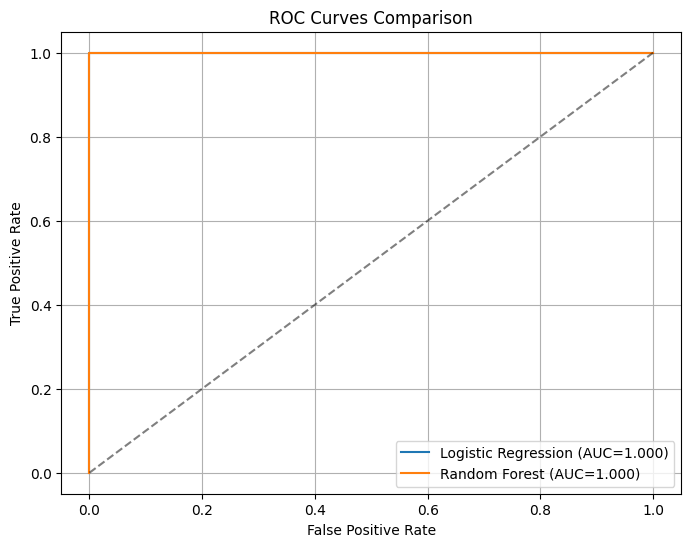

In [190]:

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_curve_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})')
plt.plot(fpr_rf, tpr_curve_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()

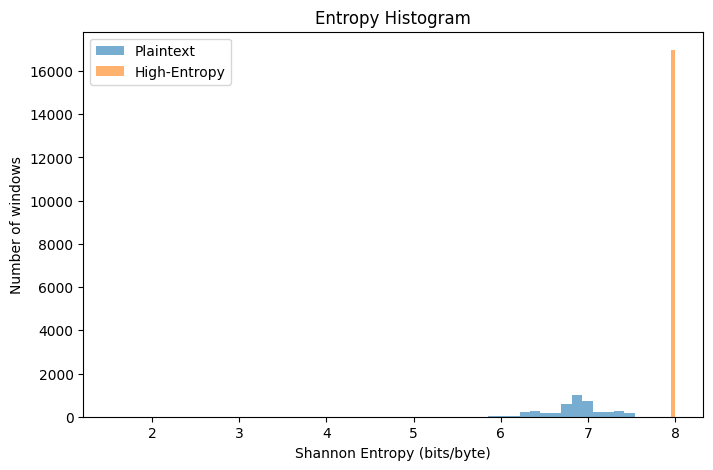

In [191]:
entropy_plain = X_balanced[y_balanced == 0, 0]
entropy_entropy = X_balanced[y_balanced == 1, 0]

plt.figure(figsize=(8,5))
plt.hist(entropy_plain, bins=50, alpha=0.6, label='Plaintext')
plt.hist(entropy_entropy, bins=50, alpha=0.6, label='High-Entropy')
plt.xlabel("Shannon Entropy (bits/byte)")
plt.ylabel("Number of windows")
plt.title("Entropy Histogram")
plt.legend()
plt.show()

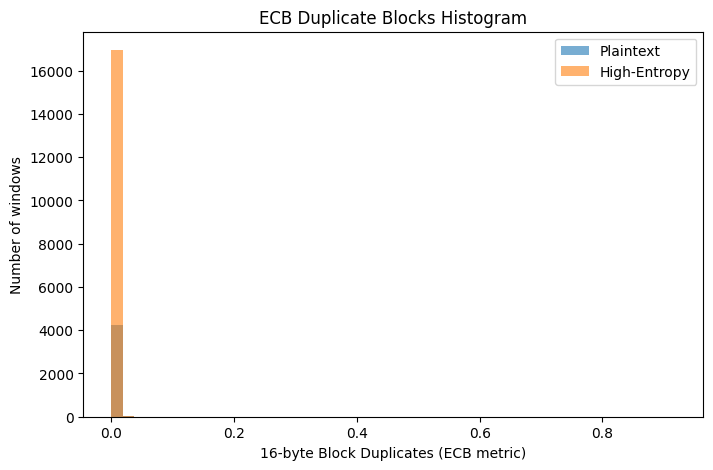

In [192]:
ecb_plain = X_balanced[y_balanced == 0, 5]
ecb_entropy = X_balanced[y_balanced == 1, 5]

plt.figure(figsize=(8,5))
plt.hist(ecb_plain, bins=50, alpha=0.6, label='Plaintext')
plt.hist(ecb_entropy, bins=50, alpha=0.6, label='High-Entropy')
plt.xlabel("16-byte Block Duplicates (ECB metric)")
plt.ylabel("Number of windows")
plt.title("ECB Duplicate Blocks Histogram")
plt.legend()
plt.show()

## Conclusions on Model Performance

1. **Logistic Regression**  
   - Achieved perfect classification with **ROC-AUC = 1.0000**.  
   - At a low false positive rate (FPR = 1%), the **true positive rate (TPR) is also 1.0000**, meaning all high-entropy windows were correctly detected with almost no misclassification of plaintext.  
   - Indicates that even a simple linear model can fully separate plaintext from high-entropy windows using the computed features (entropy, Chi-square, compressibility, serial correlation, FFT flatness, and ECB duplicates).

2. **Random Forest**  
   - Also achieved **ROC-AUC = 1.0000** and **TPR@FPR=1% = 1.0000**, matching Logistic Regression.  
   - The ensemble model likely provides additional robustness to feature interactions, but in this dataset both models reach perfect separation.

3. **Overall Interpretation**  
   - The features chosen are extremely effective at distinguishing plaintext from encrypted or random data.  
   - Both linear (Logistic Regression) and nonlinear (Random Forest) models perform perfectly on this task.  
   - Limitations remain for distinguishing among high-entropy types (AES modes, Random, zlib), as the models were trained to separate **high-entropy vs plaintext**, not to classify specific encryption algorithms.